In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# For ETS Plots
from statsmodels.tsa.seasonal import seasonal_decompose      
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse,rmse

# For determining ARIMA hyperparameters
from pmdarima import auto_arima                              

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Raw data

In [2]:
# Enter input paths for footfall data
path_footfall = 'C:/Users/medira/OneDrive - University of Leeds/Projects/AmbPop/AmbPopData/LCC_footfall_cleaned_2021.csv'

# Enter output paths for the folder storing outputs
dir_out = '../AmbPop_Outputs/'

In [3]:
# Load footfall data to pandas DataFrame
df_footfall = pd.read_csv(path_footfall, index_col='DateTime', parse_dates=True)

df_footfall['Date'] = pd.to_datetime(df_footfall['Date'])
df_footfall['Year'] = df_footfall.Date.dt.year
df_footfall['Month'] = df_footfall.Date.dt.month
df_footfall['Hour'] = df_footfall.Date.dt.hour
df_footfall['YearMonth'] = df_footfall.Date.dt.to_period('M')
df_footfall['MonthDay'] = df_footfall.Date.dt.day
df_footfall['WeekDay'] = df_footfall.Date.dt.weekday
df_footfall['WeekDayName'] = df_footfall.Date.dt.day_name()
df_footfall['IsWeekend'] = df_footfall.WeekDay > 4
df_footfall['YearMonthDay'] = df_footfall['Year'].astype(str) + '-' + df_footfall['MonthDay'].astype(str)
df_footfall['YearWeekDay'] = df_footfall['Year'].astype(str) + '-' + df_footfall['WeekDay'].astype(str)
df_footfall['YearMonthWeekDay'] = df_footfall['YearMonth'].astype(str) + '-' + df_footfall['WeekDay'].astype(str)
df_footfall['LocationYear'] = df_footfall['Location'].astype(str) + '-' + df_footfall['Year'].astype(str)
df_footfall['LocationYearMonth'] = df_footfall['Location'].astype(str) + '-' + df_footfall['YearMonth'].astype(str)


df_footfall = df_footfall[['Location', 'LocationYear', 'LocationYearMonth', 'Count', 'Date', 'Year', 'YearMonth', 'Month',
                           'YearMonthDay', 'MonthDay', 'YearWeekDay', 'WeekDay', 'YearMonthWeekDay',
                           'WeekDayName', 'IsWeekend', 'BRCWeekNum', 'BRCMonthNum', 'BRCMonth', 'BRCYear']]

df_footfall.info()
df_footfall.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Location           793558 non-null  object        
 1   LocationYear       793558 non-null  object        
 2   LocationYearMonth  793558 non-null  object        
 3   Count              793558 non-null  int64         
 4   Date               793558 non-null  datetime64[ns]
 5   Year               793558 non-null  int64         
 6   YearMonth          793558 non-null  period[M]     
 7   Month              793558 non-null  int64         
 8   YearMonthDay       793558 non-null  object        
 9   MonthDay           793558 non-null  int64         
 10  YearWeekDay        793558 non-null  object        
 11  WeekDay            793558 non-null  int64         
 12  YearMonthWeekDay   793558 non-null  object        
 13  WeekDayNam

,Location,LocationYear,LocationYearMonth,Count,Date,Year,YearMonth,Month,YearMonthDay,MonthDay,YearWeekDay,WeekDay,YearMonthWeekDay,WeekDayName,IsWeekend,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear
DateTime,,,,,,,,,,,,,,,,,,,
2020-03-08 00:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,3,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 01:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,6,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 02:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,1,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 03:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,30,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 04:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,20,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020


In [4]:
df_footfall.dropna(inplace=True)

df_footfall.info()
df_footfall.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Location           793558 non-null  object        
 1   LocationYear       793558 non-null  object        
 2   LocationYearMonth  793558 non-null  object        
 3   Count              793558 non-null  int64         
 4   Date               793558 non-null  datetime64[ns]
 5   Year               793558 non-null  int64         
 6   YearMonth          793558 non-null  period[M]     
 7   Month              793558 non-null  int64         
 8   YearMonthDay       793558 non-null  object        
 9   MonthDay           793558 non-null  int64         
 10  YearWeekDay        793558 non-null  object        
 11  WeekDay            793558 non-null  int64         
 12  YearMonthWeekDay   793558 non-null  object        
 13  WeekDayNam

,Location,LocationYear,LocationYearMonth,Count,Date,Year,YearMonth,Month,YearMonthDay,MonthDay,YearWeekDay,WeekDay,YearMonthWeekDay,WeekDayName,IsWeekend,BRCWeekNum,BRCMonthNum,BRCMonth,BRCYear
DateTime,,,,,,,,,,,,,,,,,,,
2020-03-08 00:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,3,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 01:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,6,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 02:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,1,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 03:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,30,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020
2020-03-08 04:00:00,Albion Street South,Albion Street South-2020,Albion Street South-2020-03,20,2020-03-08,2020,2020-03,3,2020-8,8,2020-6,6,2020-03-6,Sunday,True,32,8,August,2020


## Statistics

In [5]:
df_footfall_stats = df_footfall[['Location', 'Count']]

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Location  793558 non-null  object
 1   Count     793558 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 18.2+ MB


,Location,Count
DateTime,,
2020-03-08 00:00:00,Albion Street South,3
2020-03-08 01:00:00,Albion Street South,6
2020-03-08 02:00:00,Albion Street South,1
2020-03-08 03:00:00,Albion Street South,30
2020-03-08 04:00:00,Albion Street South,20


In [6]:
df_footfall_stats['NumRecords'] = df_footfall_stats.groupby('Location')['Location'].transform('count')

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793558 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Location    793558 non-null  object
 1   Count       793558 non-null  int64 
 2   NumRecords  793558 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 24.2+ MB


,Location,Count,NumRecords
DateTime,,,
2020-03-08 00:00:00,Albion Street South,3,104904
2020-03-08 01:00:00,Albion Street South,6,104904
2020-03-08 02:00:00,Albion Street South,1,104904
2020-03-08 03:00:00,Albion Street South,30,104904
2020-03-08 04:00:00,Albion Street South,20,104904


In [7]:
df_footfall_stats = df_footfall_stats[df_footfall_stats['NumRecords'] == 104904]
df_footfall_stats.drop('NumRecords', axis=1, inplace=True)

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 629424 entries, 2020-03-08 00:00:00 to 2016-11-30 23:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Location  629424 non-null  object
 1   Count     629424 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.4+ MB


,Location,Count
DateTime,,
2020-03-08 00:00:00,Albion Street South,3
2020-03-08 01:00:00,Albion Street South,6
2020-03-08 02:00:00,Albion Street South,1
2020-03-08 03:00:00,Albion Street South,30
2020-03-08 04:00:00,Albion Street South,20


In [8]:
df_footfall_stats.sort_index(inplace=True)

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 629424 entries, 2008-01-09 00:00:00 to 2021-12-04 23:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Location  629424 non-null  object
 1   Count     629424 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.4+ MB


,Location,Count
DateTime,,
2008-01-09,Briggate,115
2008-01-09,Commercial Street Combined,20
2008-01-09,Dortmund Square,14
2008-01-09,Briggate at McDonalds,28
2008-01-09,Headrow,8


In [9]:
df_footfall_stats = df_footfall_stats.loc[pd.Timestamp('2008-01-01'):pd.Timestamp('2020-01-01')]

df_footfall_stats.info()
df_footfall_stats.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 560166 entries, 2008-01-09 00:00:00 to 2020-01-01 00:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Location  560166 non-null  object
 1   Count     560166 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.8+ MB


,Location,Count
DateTime,,
2008-01-09,Briggate,115
2008-01-09,Commercial Street Combined,20
2008-01-09,Dortmund Square,14
2008-01-09,Briggate at McDonalds,28
2008-01-09,Headrow,8


In [10]:
df_footfall_stats.groupby('Location').describe()

Count                                        \
                              count         mean          std  min    25%   
Location                                                                    
Albion Street South         93361.0  1079.845385  1581.380841  0.0   79.0   
Briggate                    93361.0  1395.384208  1712.852546  0.0  217.0   
Briggate at McDonalds       93361.0   637.965446   650.727155  0.0   97.0   
Commercial Street Combined  93361.0  1151.281049  1627.860822  0.0   66.0   
Dortmund Square             93361.0   970.176316  1157.347395  0.0   89.0   
Headrow                     93361.0   670.190540   760.629163  0.0   74.0   

                                                    
                              50%     75%      max  
Location                                            
Albion Street South         367.0  1606.0  23268.0  
Briggate                    614.0  2134.0  19820.0  
Briggate at McDonalds       360.0  1101.0   5652.0  
Commercial Street Combined  311.0  1870.0  19745.0  
Dortmund Square             445.0  1609.0  10073.0  
Headrow                     320.0  1150.0   6717.0

In [11]:
location_list = df_footfall_stats['Location'].unique()

df_footfall_stats_dict = {loc : pd.DataFrame() for loc in location_list}

for key in df_footfall_stats_dict.keys():
    df_footfall_stats_dict[key] = df_footfall_stats[:][df_footfall_stats['Location'] == key]
    df_footfall_stats_dict[key].drop('Location', axis=1, inplace=True)
    
df_footfall_stats_dict['Headrow'].info()
df_footfall_stats_dict['Headrow'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93361 entries, 2008-01-09 00:00:00 to 2020-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   93361 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


,Count
DateTime,
2008-01-09 00:00:00,8
2008-01-09 01:00:00,9
2008-01-09 02:00:00,3
2008-01-09 03:00:00,6
2008-01-09 04:00:00,8


Location: Briggate


<Figure size 432x288 with 0 Axes>

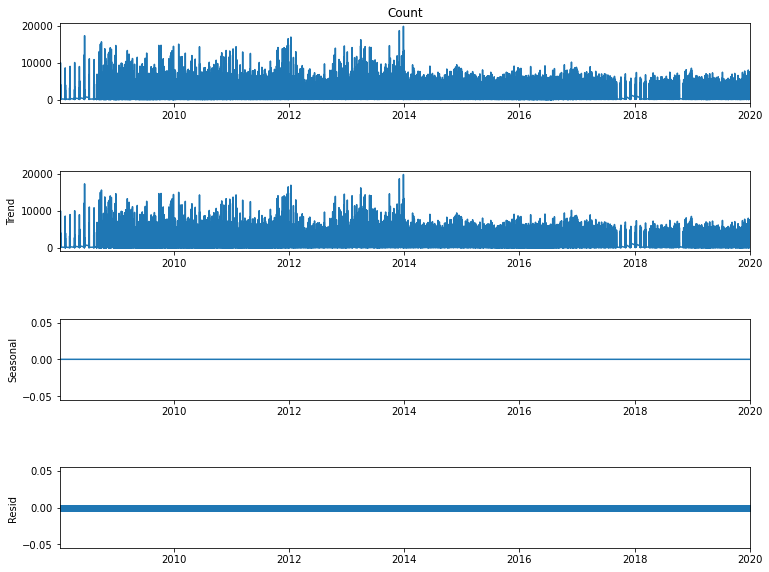

Location: Commercial Street Combined


<Figure size 432x288 with 0 Axes>

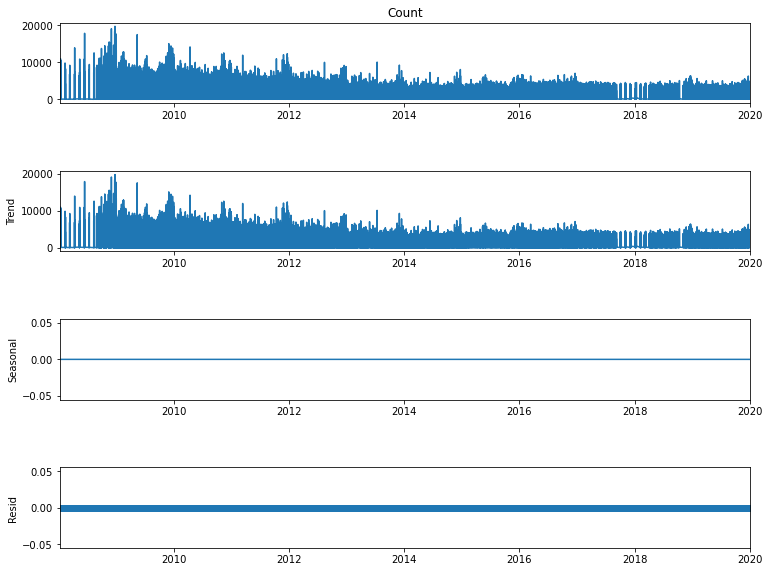

Location: Dortmund Square


<Figure size 432x288 with 0 Axes>

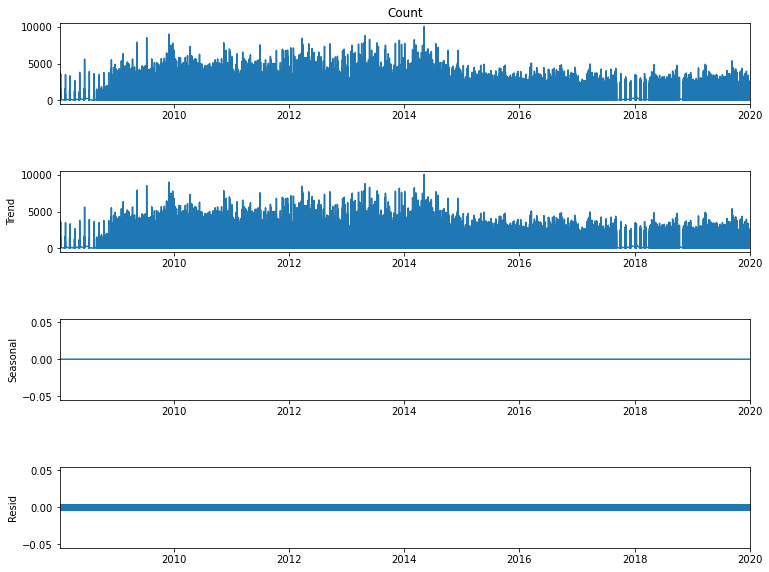

Location: Briggate at McDonalds


<Figure size 432x288 with 0 Axes>

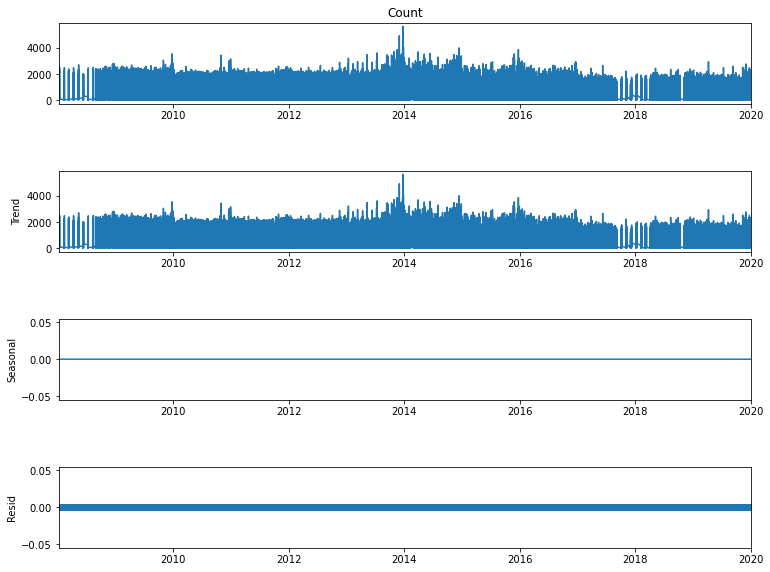

Location: Headrow


<Figure size 432x288 with 0 Axes>

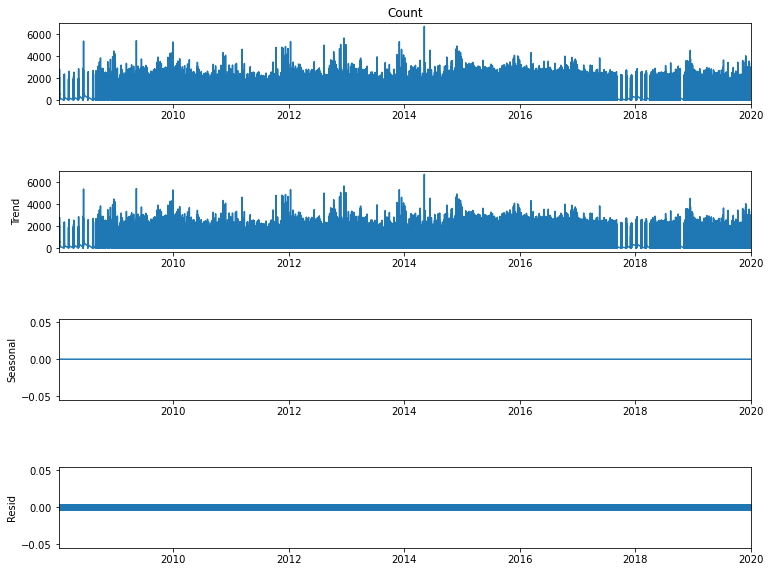

Location: Albion Street South


<Figure size 432x288 with 0 Axes>

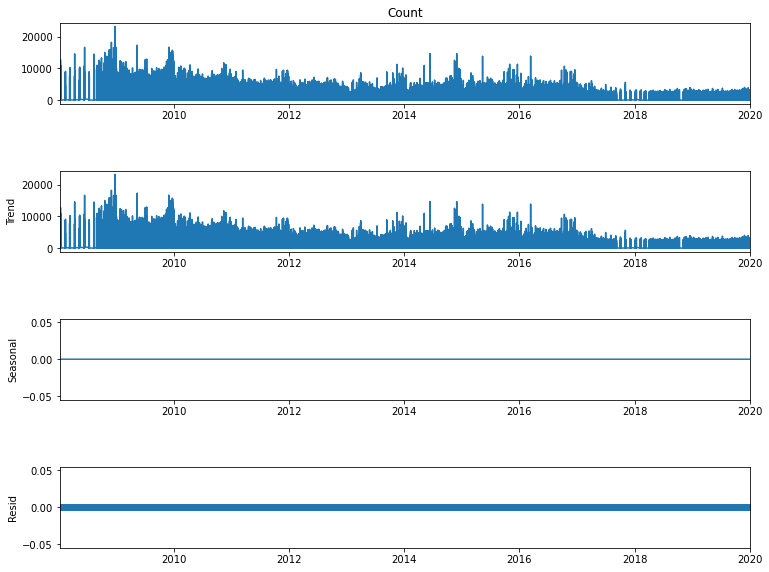

In [12]:
for key in df_footfall_stats_dict.keys():
    result = seasonal_decompose(df_footfall_stats_dict[key]['Count'], period=1)
    print('Location: ' + key)
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(12, 9)
    plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller

def plot(ts, name, sec, choice):
    
    plt.rcParams["figure.figsize"] = (15,10)
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.plot(ts, color='blue',label='Original')
    
    if 'rolmean' in choice:
        rolmean = ts.rolling(sec).mean()
        plt.plot(rolmean, color='red', label='Rolling Mean')
    if 'rolstd' in choice:
        rolstd = ts.rolling(sec).std()
        plt.plot(rolstd, color='black', label = 'Rolling Std')
    if 'expmean' in choice:
        expmean = ts.ewm(sec).mean()
        eplt.plot(expmean, color='green', label = 'Exp Mean')
        
        
    plt.legend(loc='best')
    ax.set_ylabel('Count')
    ax.set_xlabel('DateTime')
    plt.title(str(name), fontsize=15)
    ax.tick_params(axis='x', rotation=45)
    plt.show()

def test_stationarity(ts, name, sec, choice):
    
    plot(ts, name, sec, choice)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

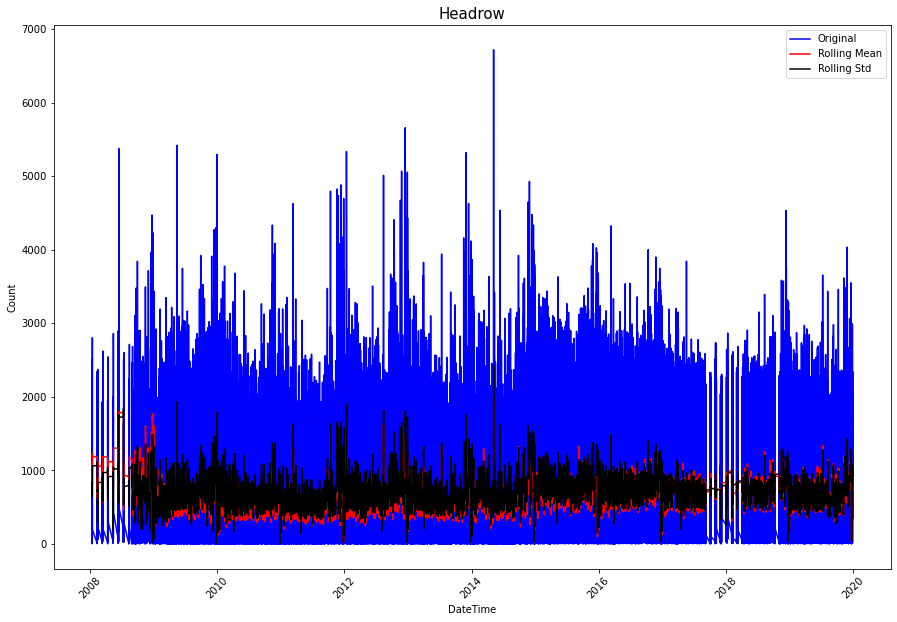

Results of Dickey-Fuller Test:
Test Statistic                   -24.519891
p-value                            0.000000
#Lags Used                        67.000000
Number of Observations Used    93293.000000
Critical Value (1%)               -3.430420
Critical Value (5%)               -2.861571
Critical Value (10%)              -2.566786
dtype: float64


In [14]:
test_stationarity(df_footfall_stats_dict['Headrow'], 'Headrow', 24, set(['rolmean', 'rolstd']))

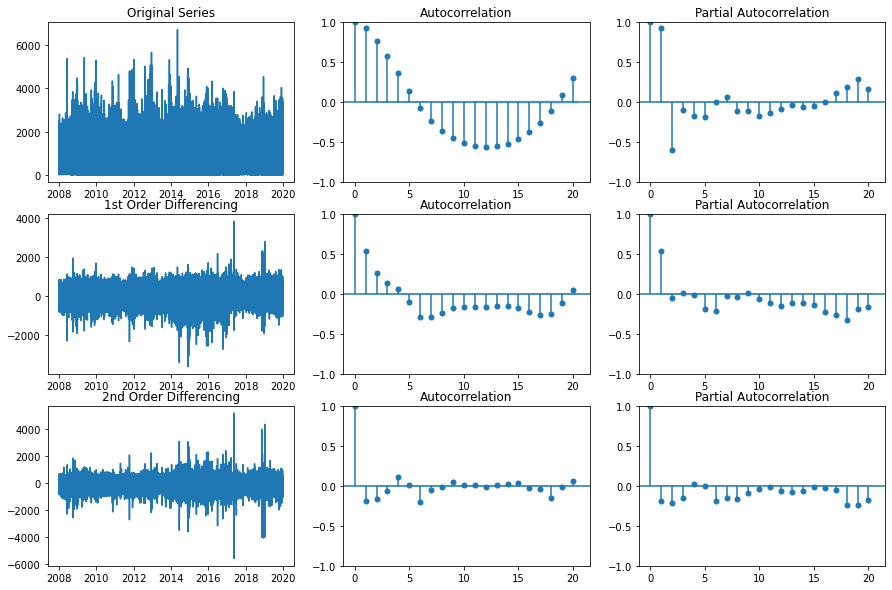

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(df_footfall_stats_dict['Headrow']); axes[0, 0].set_title('Original Series')
plot_acf(df_footfall_stats_dict['Headrow'], ax=axes[0, 1], lags=20)
plot_pacf(df_footfall_stats_dict['Headrow'], ax=axes[0, 2], lags=20)

# 1st Differencing
axes[1, 0].plot(df_footfall_stats_dict['Headrow'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_footfall_stats_dict['Headrow'].diff().dropna(), ax=axes[1, 1], lags=20)
plot_pacf(df_footfall_stats_dict['Headrow'].diff().dropna(), ax=axes[1, 2], lags=20)


# 2nd Differencing
axes[2, 0].plot(df_footfall_stats_dict['Headrow'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_footfall_stats_dict['Headrow'].diff().diff().dropna(), ax=axes[2, 1], lags=20)
plot_pacf(df_footfall_stats_dict['Headrow'].diff().diff().dropna(), ax=axes[2, 2], lags=20)

plt.show()

In [19]:
from pmdarima.arima.utils import ndiffs

## Adf Test
#ndiffs(df_footfall_stats_dict['Headrow'], test='adf')  #0

# KPSS test
#ndiffs(df_footfall_stats_dict['Headrow'], test='kpss')  #1

# PP test:
#ndiffs(df_footfall_stats_dict['Headrow'], test='pp') #0

1

In [20]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_footfall_stats_dict['Headrow'], order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                93361
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -646970.967
Date:                Mon, 22 Aug 2022   AIC                        1293949.934
Time:                        01:26:49   BIC                        1293987.711
Sample:                             0   HQIC                       1293961.434
                              - 93361                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        670.1903     14.797     45.292      0.000     641.188     699.192
ar.L1          0.8806      0.002    568.804      0.000       0.878       0.884
ma.L1          0.4971      0.002    313.474      0.0

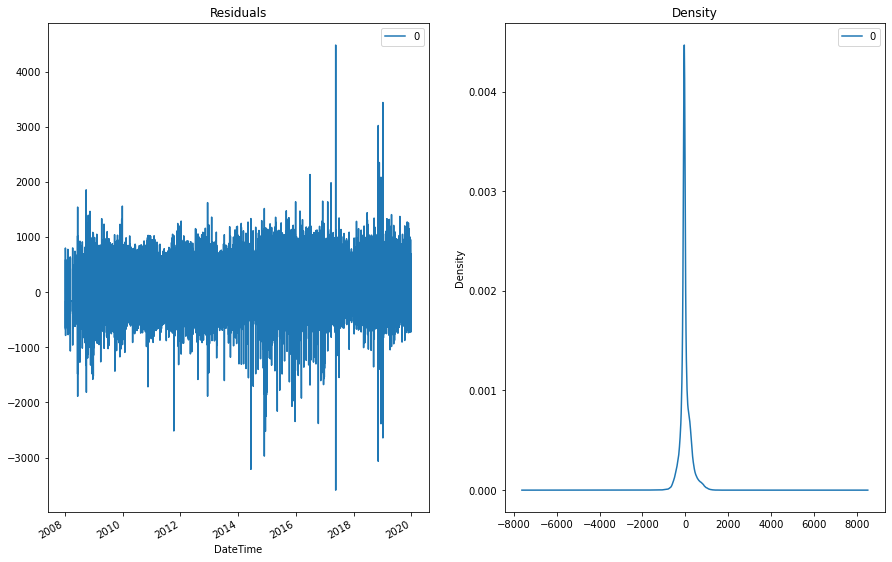

In [21]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

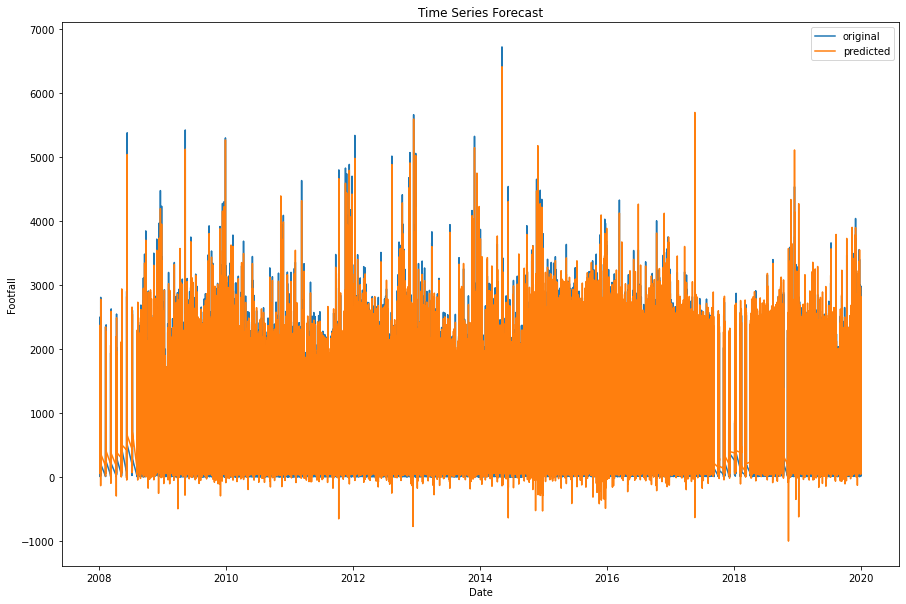

In [22]:
forecast = model_fit.predict()

fig, ax = plt.subplots(1, 1)
plt.plot(df_footfall_stats_dict['Headrow'], label = "original")
plt.plot(forecast, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Footfall")
plt.legend()
plt.show()

In [ ]:
# model_autoarima = auto_arima(df_footfall_stats_dict['Headrow']['Count'], seasonal=True, m=12)
# model_autoarima.summary()

In [ ]:
# model_autoarima.plot_diagnostics(figsize=(15,8))
# plt.show()

In [ ]:
train = df_footfall_stats_dict['Headrow'].loc[:pd.Timestamp('2019-01-01')]
test = df_footfall_stats_dict['Headrow'].loc[pd.Timestamp('2019-01-01'):]

In [ ]:
time_index = df_footfall_stats_dict['Headrow'].reset_index()[['DateTime']]
time_index = time_index[time_index['DateTime'] > pd.Timestamp('2019-01-01')]
time_index.info()
time_index.head()

In [ ]:
model = SARIMAX(train['Count'],order=(1,0,1), seasonal_order=(1,0,1,12), enforce_invertibility=False)
results = model.fit()
results.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('Predicted')

predictions.info()
predictions.head()

In [ ]:
prediction = pd.DataFrame(predictions).join(time_index)
prediction.set_index('DateTime', inplace=True)

In [ ]:
prediction.info()
prediction.head()

In [ ]:
test['Count'].plot(legend=True,figsize=(12,8))
prediction.plot(legend=True, color = 'orange')

In [ ]:
error1 = mse(test['Count'], predictions)
error2 = rmse(test['Count'], predictions)

print(f'SARIMA(1,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')

In [ ]:
df_footfall_stats_dict['Albion Street South'].info()
df_footfall_stats_dict['Albion Street South'].head()

In [ ]:
df_footfall_stats_dict['Albion Street South'][df_footfall_stats_dict['Albion Street South']['Count'].isna()]

In [ ]:
time_list=pd.date_range(start='1/9/2008', end='1/1/2020', freq='H')
print(time_list)

In [ ]:
df_footfall_stats_dict['Albion Street South'] = df_footfall_stats_dict['Albion Street South'].reindex(time_list, fill_value=np.nan)
df_footfall_stats_dict['Albion Street South'].info()
df_footfall_stats_dict['Albion Street South'].head()

In [ ]:
df_footfall_stats_dict['Albion Street South'][df_footfall_stats_dict['Albion Street South']['Count'].isna()]

In [ ]:
model_nan = ARIMA(df_footfall_stats_dict['Albion Street South']['Count'], order=(1,0,1))
model_nan_fit = model_nan.fit()
print(model_nan_fit.summary())

In [ ]:
forecast_nan = model_nan_fit.predict()

fig, ax = plt.subplots(1, 1)
plt.plot(df_footfall_stats_dict['Albion Street South'], label = "original")
plt.plot(forecast_nan, label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Footfall")
plt.legend()
plt.show()

In [ ]:
train_na = df_footfall_stats_dict['Albion Street South'].loc[:pd.Timestamp('2019-01-01')]
test_na = df_footfall_stats_dict['Albion Street South'].loc[pd.Timestamp('2019-01-01 01:00:00'): pd.Timestamp('2019-01-02')]
actual_na = df_footfall_stats_dict['Albion Street South'].loc[:pd.Timestamp('2019-01-02')]

In [ ]:
train_na.tail(5)

In [ ]:
test_na.head(25)

In [ ]:
model_na_fc = ARIMA(train_na, order=(1, 0, 1))  
model_na_fc_fit = model_na_fc.fit()  

In [ ]:
# Forecast
fc = model_na_fc_fit.forecast(24)  # 95% conf

In [ ]:
print(fc)

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_na.loc[pd.Timestamp('2018-12-31'): pd.Timestamp('2019-01-01')], label='training')
plt.plot(test_na.loc[pd.Timestamp('2019-01-01 01:00:00'): pd.Timestamp('2019-01-02')], label='actual')
plt.plot(fc.loc[pd.Timestamp('2019-01-01 01:00:00'): pd.Timestamp('2019-01-02')], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

use one month before for predicting one day (apply accordingly)
seasonality - sarima (have diff seasonalities (hourly, monthly...), arima x no seasonality)
exogenous variables before adding seasonality (careful with misinfo)